<a href="https://colab.research.google.com/github/gabrielhenriquess/TelecomX_II/blob/main/TelecomX_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📊 TelecomX – Parte 2: Predição de Evasão (Evasão)
###Pipeline simples e didático: preparação → modelagem → avaliação → interpretação.


##🛠 Etapa 1 — Carregar e inspecionar os dados

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE


##📌 Etapa 2 - Carregar dados

In [109]:
df = pd.read_csv('/content/telecomx_tratado.csv')
df.head()


,id_cliente,evasao,sexo,categoria_idoso,tem_parceiro,tem_dependentes,tempo_contrato,telefone_ativo,multiplas_linhas,tipo_internet,...,protecao_aparelho,suporte_online,tv_stream,filmes_stream,modelo_contrato,fatura_online,pagamento,media_diaria,mensalidade,total_gasto
0,0002-ORFBO,nao,mulher,nao,sim,sim,9,sim,nao,dsl,...,nao,sim,sim,nao,anual,sim,cheque_correio,2.20,65.6,593.30
1,0003-MKNFE,nao,homem,nao,nao,nao,9,sim,sim,dsl,...,nao,nao,nao,sim,mensal,nao,cheque_correio,2.01,59.9,542.40
2,0004-TLHLJ,sim,homem,nao,nao,nao,4,sim,nao,fibra,...,sim,nao,nao,nao,mensal,sim,cheque_online,2.34,73.9,280.85
3,0011-IGKFF,sim,homem,sim,sim,nao,13,sim,nao,fibra,...,sim,nao,sim,sim,mensal,sim,cheque_online,3.17,98.0,1237.85
4,0013-EXCHZ,sim,mulher,sim,sim,nao,3,sim,nao,fibra,...,nao,sim,sim,nao,mensal,sim,cheque_correio,2.97,83.9,267.40


##📌 Etapa 2.1 — Análise exploratória inicia

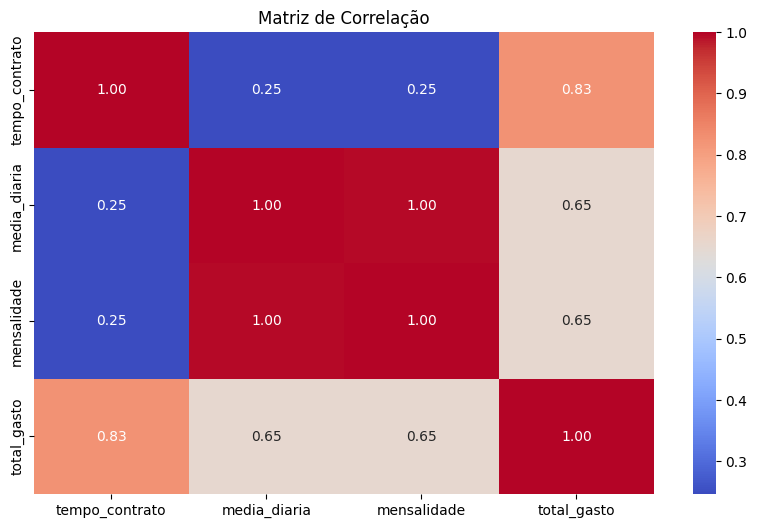

In [110]:
# 1. Matriz de correlação (apenas numéricas)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

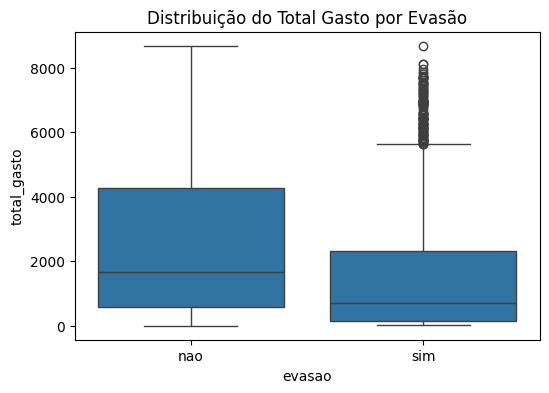

In [111]:
# 2. Boxplot: Total gasto x Evasão
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='evasao', y='total_gasto')
plt.title("Distribuição do Total Gasto por Evasão")
plt.show()

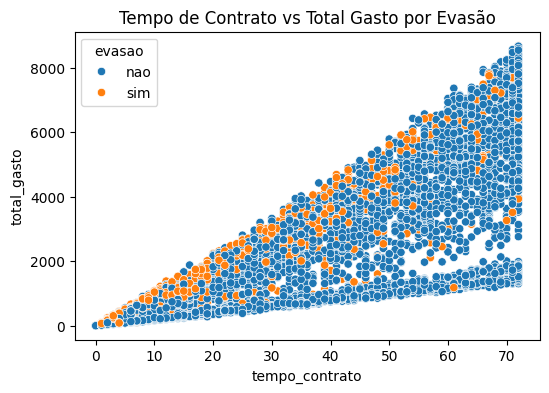

In [112]:
# 3. Scatter plot: Tempo de contrato vs Total gasto
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='tempo_contrato', y='total_gasto', hue='evasao')
plt.title("Tempo de Contrato vs Total Gasto por Evasão")
plt.show()

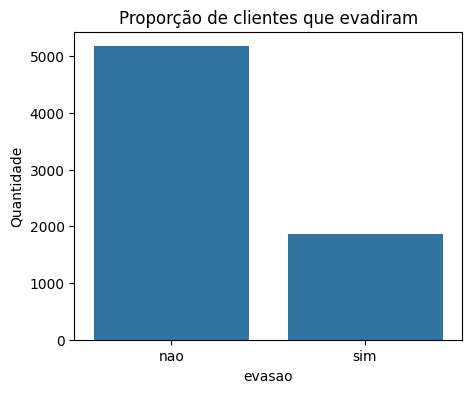

Contagem de evasão:
 evasao
nao    5174
sim    1869
Name: count, dtype: int64

Proporção de evasão:
 evasao
nao    0.73
sim    0.27
Name: proportion, dtype: float64


In [113]:
# 4. Histograma: proporção de evasão
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='evasao')
plt.title("Proporção de clientes que evadiram")
plt.ylabel("Quantidade")
plt.show()

# Mostrar valores absolutos e proporcionais
print("Contagem de evasão:\n", df['evasao'].value_counts())
print("\nProporção de evasão:\n", df['evasao'].value_counts(normalize=True).round(2))

##📌 Etapa 2.2 — Resumo estatístico dos dados

In [114]:
# Estatísticas descritivas das variáveis numéricas
print("📊 Estatísticas descritivas (numéricas):")
display(df.describe())

# Estatísticas descritivas das variáveis categóricas
print("\n📊 Estatísticas descritivas (categóricas):")
display(df.describe(include=['object']))

# Conferir valores únicos por coluna (útil para encoding)
print("\n🔍 Valores únicos por coluna:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} valores únicos")


📊 Estatísticas descritivas (numéricas):


,tempo_contrato,media_diaria,mensalidade,total_gasto
count,7043.000000,7032.000000,7043.000000,7043.000000
mean,32.371149,2.159879,64.761692,2279.734304
std,24.559481,1.006217,30.090047,2266.794470
min,0.000000,0.460000,18.250000,0.000000
25%,9.000000,1.207500,35.500000,398.550000
50%,29.000000,2.350000,70.350000,1394.550000
75%,55.000000,3.010000,89.850000,3786.600000
max,72.000000,4.050000,118.750000,8684.800000



📊 Estatísticas descritivas (categóricas):


,id_cliente,evasao,sexo,categoria_idoso,tem_parceiro,tem_dependentes,telefone_ativo,multiplas_linhas,tipo_internet,seguranca_online,backup_nuvem,protecao_aparelho,suporte_online,tv_stream,filmes_stream,modelo_contrato,fatura_online,pagamento
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,9995-HOTOH,nao,homem,nao,nao,nao,sim,nao,fibra,nao,nao,nao,nao,nao,nao,mensal,sim,cheque_online
freq,1,5174,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365



🔍 Valores únicos por coluna:
id_cliente: 7043 valores únicos
evasao: 2 valores únicos
sexo: 2 valores únicos
categoria_idoso: 2 valores únicos
tem_parceiro: 2 valores únicos
tem_dependentes: 2 valores únicos
tempo_contrato: 73 valores únicos
telefone_ativo: 2 valores únicos
multiplas_linhas: 3 valores únicos
tipo_internet: 3 valores únicos
seguranca_online: 3 valores únicos
backup_nuvem: 3 valores únicos
protecao_aparelho: 3 valores únicos
suporte_online: 3 valores únicos
tv_stream: 3 valores únicos
filmes_stream: 3 valores únicos
modelo_contrato: 3 valores únicos
fatura_online: 2 valores únicos
pagamento: 4 valores únicos
media_diaria: 354 valores únicos
mensalidade: 1585 valores únicos
total_gasto: 6531 valores únicos


##📌 Etapa 3 - Checagens rápidas

In [115]:
print(df.shape)
print(df.columns.tolist()[:25])
df.info()
df.isnull().sum().sort_values(ascending=False).head(10)


(7043, 22)
['id_cliente', 'evasao', 'sexo', 'categoria_idoso', 'tem_parceiro', 'tem_dependentes', 'tempo_contrato', 'telefone_ativo', 'multiplas_linhas', 'tipo_internet', 'seguranca_online', 'backup_nuvem', 'protecao_aparelho', 'suporte_online', 'tv_stream', 'filmes_stream', 'modelo_contrato', 'fatura_online', 'pagamento', 'media_diaria', 'mensalidade', 'total_gasto']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_cliente         7043 non-null   object 
 1   evasao             7043 non-null   object 
 2   sexo               7043 non-null   object 
 3   categoria_idoso    7043 non-null   object 
 4   tem_parceiro       7043 non-null   object 
 5   tem_dependentes    7043 non-null   object 
 6   tempo_contrato     7043 non-null   int64  
 7   telefone_ativo     7043 non-null   object 
 8   multiplas_linhas   7043 non-null   ob

,0
media_diaria,11
id_cliente,0
sexo,0
categoria_idoso,0
tem_parceiro,0
evasao,0
tem_dependentes,0
tempo_contrato,0
multiplas_linhas,0
telefone_ativo,0


##📌 Etapa 4 — Remover colunas irrelevantes

In [116]:
# Remover coluna de identificador, se existir
if 'id_cliente' in df.columns:
    df = df.drop(columns=['id_cliente'])

df.head()


,evasao,sexo,categoria_idoso,tem_parceiro,tem_dependentes,tempo_contrato,telefone_ativo,multiplas_linhas,tipo_internet,seguranca_online,...,protecao_aparelho,suporte_online,tv_stream,filmes_stream,modelo_contrato,fatura_online,pagamento,media_diaria,mensalidade,total_gasto
0,nao,mulher,nao,sim,sim,9,sim,nao,dsl,nao,...,nao,sim,sim,nao,anual,sim,cheque_correio,2.20,65.6,593.30
1,nao,homem,nao,nao,nao,9,sim,sim,dsl,nao,...,nao,nao,nao,sim,mensal,nao,cheque_correio,2.01,59.9,542.40
2,sim,homem,nao,nao,nao,4,sim,nao,fibra,nao,...,sim,nao,nao,nao,mensal,sim,cheque_online,2.34,73.9,280.85
3,sim,homem,sim,sim,nao,13,sim,nao,fibra,nao,...,sim,nao,sim,sim,mensal,sim,cheque_online,3.17,98.0,1237.85
4,sim,mulher,sim,sim,nao,3,sim,nao,fibra,nao,...,nao,sim,sim,nao,mensal,sim,cheque_correio,2.97,83.9,267.40


##📌 Etapa 5 - Separar alvo e features (antes do encoding)

In [117]:
# Caso alvo esteja em texto 'evasao' (sim/nao)
if 'evasao' in df.columns:
    y = df['evasao'].astype(str).str.strip().str.lower().map({'sim':1, 'nao':0})
    X = df.drop(columns=['evasao'])
# Caso alvo já esteja em dummy 'evasao_sim'
elif 'evasao_sim' in df.columns:
    y = df['evasao_sim'].astype(int)
    X = df.drop(columns=['evasao_sim'])
else:
    raise ValueError("Não encontrei a coluna alvo ('evasao' ou 'evasao_sim').")


##📌 Etapa 6 -  One-Hot Encoding

In [118]:
X = pd.get_dummies(X, drop_first=True)


##📌 Etapa 7 - Imputação de nulos

In [119]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


##📌 Etapa 8 - Balanceamento com SMOTE

In [120]:
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_imputed, y)

pd.Series(y_bal).value_counts(normalize=True)


,proportion
evasao,
0,0.5
1,0.5


##📌 Etapa 9 - Normalização (necessária para LogReg/KNN/SVM)

In [121]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bal)


##📌 Etapa 10 - Split treino/teste (70/30)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_bal, test_size=0.3, random_state=42
)


##📌 Etapa 11 - Treinar modelos

In [123]:
# Regressão Logística
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

##📌 Etapa 12 - Avaliação (relatório + matriz)

In [124]:
print("📊 Regressão Logística")
y_pred_log = log_model.predict(X_test)
print(classification_report(y_test, y_pred_log))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_log))

print("\n🌲 Random Forest")
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print("Matriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf))


📊 Regressão Logística
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1588
           1       0.73      0.81      0.77      1517

    accuracy                           0.77      3105
   macro avg       0.77      0.77      0.77      3105
weighted avg       0.77      0.77      0.77      3105

Matriz de Confusão:
 [[1141  447]
 [ 281 1236]]

🌲 Random Forest
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1588
           1       0.87      0.83      0.85      1517

    accuracy                           0.86      3105
   macro avg       0.86      0.85      0.86      3105
weighted avg       0.86      0.86      0.86      3105

Matriz de Confusão:
 [[1401  187]
 [ 262 1255]]


##📌 Etapa 13 - Curva ROC + AUC (comparação visual)

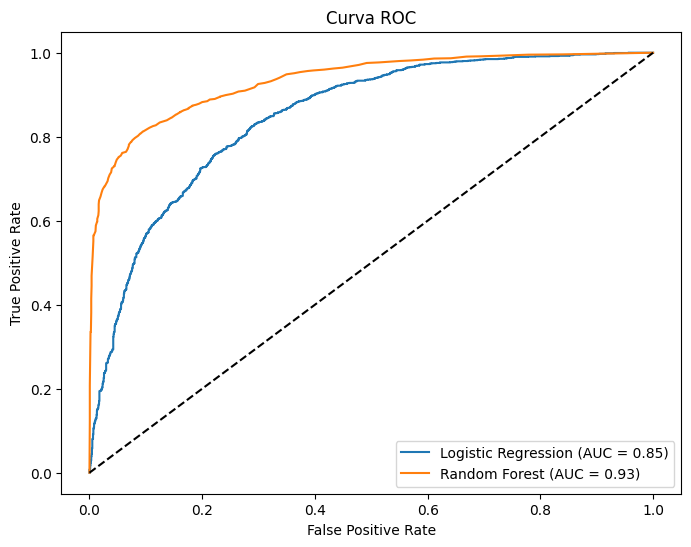

In [125]:
y_prob_log = log_model.predict_proba(X_test)[:, 1]
y_prob_rf  = rf_model.predict_proba(X_test)[:, 1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_prob_rf)

auc_log = auc(fpr_log, tpr_log)
auc_rf  = auc(fpr_rf,  tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.2f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(); plt.show()


##📌 Etapa 14 - Importância das variáveis (RF)

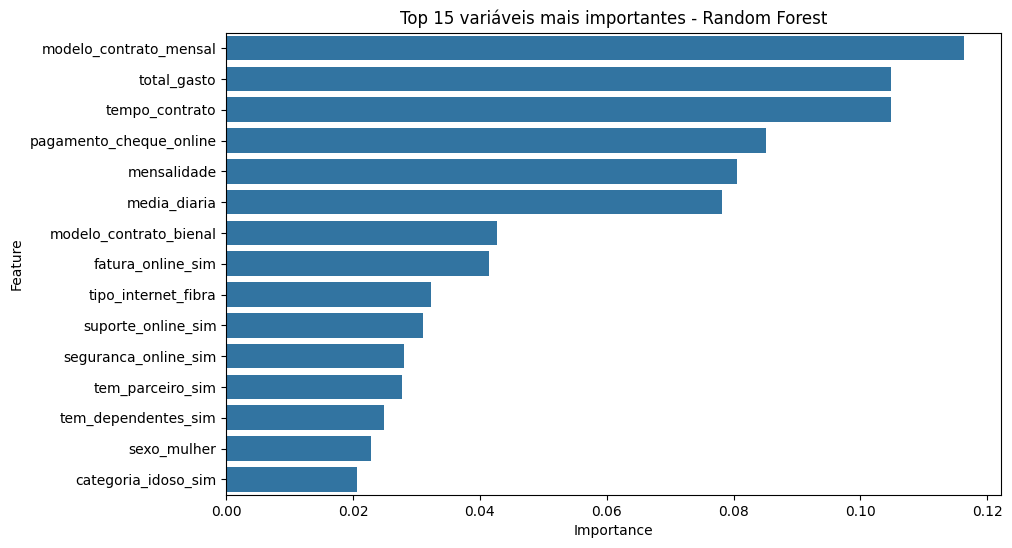

,Feature,Importance
26,modelo_contrato_mensal,0.116408
3,total_gasto,0.104859
0,tempo_contrato,0.104834
29,pagamento_cheque_online,0.085178
2,mensalidade,0.080564
1,media_diaria,0.078254
25,modelo_contrato_bienal,0.042691
27,fatura_online_sim,0.041495
11,tipo_internet_fibra,0.032297
20,suporte_online_sim,0.031044


In [126]:
importances = rf_model.feature_importances_
features = X.columns

feat_importance = pd.DataFrame({'Feature': features, 'Importance': importances}) \
                    .sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_importance.head(15), x='Importance', y='Feature')
plt.title("Top 15 variáveis mais importantes - Random Forest")
plt.show()

feat_importance.head(20)


##📌 Etapa 15 - Comparação de métricas (tabela + gráfico)

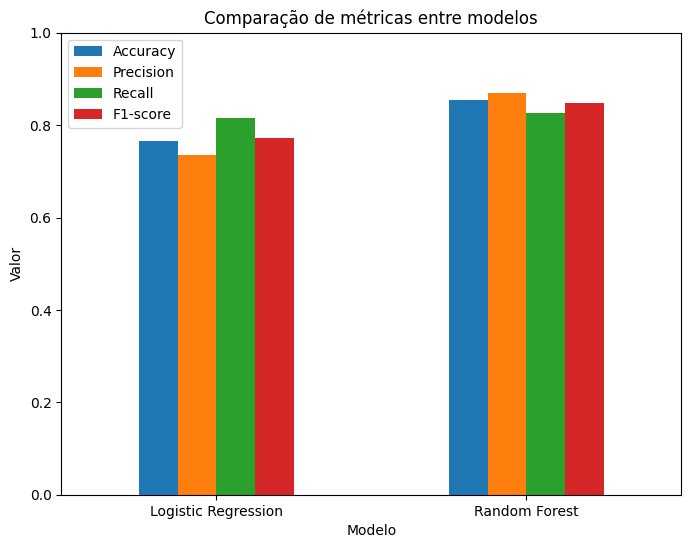

,Modelo,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.765539,0.734403,0.814766,0.77250
1,Random Forest,0.855395,0.870319,0.827291,0.84826


In [127]:
metrics_df = pd.DataFrame({
    'Modelo': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_rf)],
    'Precision': [precision_score(y_test, y_pred_log), precision_score(y_test, y_pred_rf)],
    'Recall': [recall_score(y_test, y_pred_log), recall_score(y_test, y_pred_rf)],
    'F1-score': [f1_score(y_test, y_pred_log), f1_score(y_test, y_pred_rf)]
})

ax = metrics_df.set_index('Modelo').plot(kind='bar', figsize=(8,6))
plt.title("Comparação de métricas entre modelos")
plt.ylabel("Valor"); plt.ylim(0, 1); plt.xticks(rotation=0)
plt.show()

metrics_df


#📌 Etapa 16 — Conclusão estratégica

# 📊 Conclusões e Recomendações Estratégicas

## 1️⃣ Desempenho dos Modelos
- **Random Forest** apresentou o melhor desempenho geral, com maior F1-score, Recall e AUC.
- **Regressão Logística** também obteve bons resultados, mas com desempenho levemente inferior ao RF.

## 2️⃣ Principais Fatores de Evasão
Com base na importância das variáveis do Random Forest e na análise exploratória:
- **Tempo de contrato**: clientes com pouco tempo de vínculo tendem a evadir mais.
- **Tipo de contrato**: contratos mensais apresentam maior risco de evasão.
- **Total gasto**: clientes com menor gasto acumulado tendem a cancelar mais.
- **Método de pagamento**: algumas formas de pagamento estão associadas a maior evasão (ex.: boleto).

## 3️⃣ Insights da Análise Exploratória
- Contratos de curto prazo e baixo gasto apresentam maior proporção de evasão.
- O desbalanceamento inicial entre clientes ativos e evadidos foi significativo, justificando o uso do SMOTE.

## 4️⃣ Recomendações para a TelecomX
- Incentivar **contratos anuais ou semestrais**, oferecendo descontos e benefícios.
- Criar **programas de fidelização** voltados para os primeiros meses de contrato.
- Estimular **pagamentos automáticos** (débito/cartão) para reduzir inadimplência.
- Investir em campanhas direcionadas para **clientes de baixo gasto**.

---
📌 **Resumo Final**: O uso de modelos preditivos permite à TelecomX antecipar riscos de evasão e agir preventivamente. A combinação de análises exploratórias, modelagem e interpretação garante um suporte sólido à tomada de decisão.
